# SNAX package tutorial

In [31]:
from snewpy.neutrino import Flavor
import os
from tqdm.notebook import tqdm
import numpy as np
from multimessenger.supernova import Supernova_Models as sn
from multimessenger.supernova.Plotter import Plotter
import plotly.express as px
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

The `SNAX` is a wrapper around `snewpy` and it allows to compute CEvNS rates for all the snewpy models.

In [2]:
# sn.models_list

Each model contains variuous simulations with e.g. different EoS, or different progenitor properties. <br>
When only `model_name` is passed to `sn.Models()` it displays the existing files and asks you to select one. Otherwise, `filename` or `index` can be passed. <br>
Once the model is executed, and after every heavy computation the data is saved, and the next time it is directly fetched from the stored data. <br>
The output folder can be specified with the `storage` argument.

In [3]:
# A.delete_object()

In [4]:
# A = sn.Models(model_name='Fornax_2021',index=5, storage="../../../scratch/SN_rewiev/", config_file="../simple_config.conf") #  
A = sn.Models(model_name='Fornax_2021', index=5)

> You chose ~wisely~ ->	   [5]	lum_spec_15M_r10000_dat.h5
> Retrieving object self.storage/15.0 solMass.pickle


In [5]:
A.compute_rates();

Computing for all isotopes:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

One can also get a plotter, which takes the model object as input and allows for easy plotting. 

In [6]:
# plotter = Plotter(A)

In [7]:
# plotter.plot_cross_section_fantastic()

In [8]:
# plotter.plot_recoil_spectrum()

In [9]:
# plotter.plot_form_factor()

In [10]:
# plotter.plot_cross_section();

In [11]:
# # not all models have same attributes
# # plotter.plot_mean_cross_section(); # --> doesn't work as there are no meanE attribute in Fornax
# B = sn.Models(model_name='Nakazato_2013', index=10)
# plotter_B = Plotter(B)
# plotter_B.plot_mean_cross_section();

In [10]:
# plotter_B.plot_params()

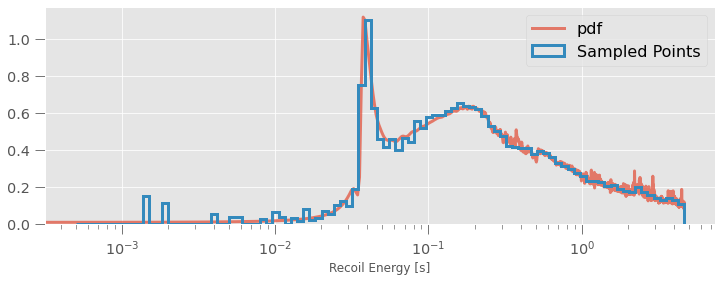

In [9]:
sampled_t = plotter.plot_sampled_data(50000, dtype="time", xscale="log");

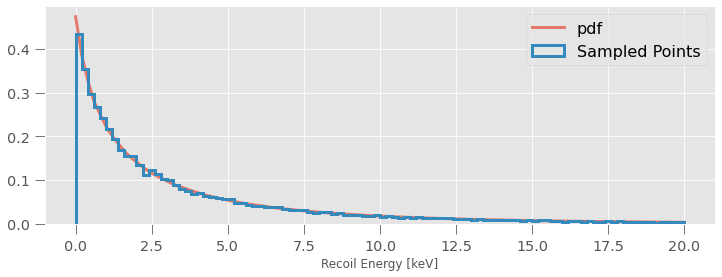

In [10]:
sampled_Er = plotter.plot_sampled_data(50000, xscale='lin');

In [12]:
N_events = 1000
sampled_Er = A.sample_data(N_events)
sampled_t = A.sample_data(N_events, dtype='time')

These parts are better done in dali/midway. <br>


In [13]:
from multimessenger.supernova.Simulate import generator_sn_instruction
import nestpy
import pandas as pd
import straxen
downloader = straxen.MongoDownloader()

*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [14]:
field_file="fieldmap_2D_B2d75n_C2d75n_G0d3p_A4d9p_T0d9n_PMTs1d3n_FSR0d65p_QPTFE_0d5n_0d4p.json.gz"
field_map = straxen.InterpolatingMap(
                    straxen.get_resource(downloader.download_single(field_file),
                                         fmt="json.gz"),
                    method="RegularGridInterpolator")

Caution, the times need to be passed in nanoseconds!

In [15]:
nc = nestpy.NESTcalc(nestpy.DetectorExample_XENON10())
## not sure if nestpy RNG issue was solved, so randomize NEST internal state
for i in range(np.random.randint(100)):
    nc.GetQuanta(nc.GetYields(energy=np.random.uniform(10,100)))
    
instr = generator_sn_instruction(energy_deposition=sampled_Er, timemode=sampled_t*1e9, n_tot=N_events, nc=nc, fmap=field_map)
df = pd.DataFrame(instr)

*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [16]:
# df

Simulate one run, and get back the context.

In [24]:
runid = "snsim_02"
# st = A.simulate_one(df, runid)

Or one can create a context with the desired configuration and pass that context for simulation.

In [25]:
import cutax, strax
st = cutax.contexts.xenonnt_sim_SR0v1_cmt_v8(cmt_run_id="026000")

/dali/lgrandi/xenonnt/software/cutax/latest/cutax/contexts.py:85: UserWarning: WARNING! You are using SR0 v1 simulation context! Consider updating to a newer version!
  warnings.warn("WARNING! You are using SR0 v1 simulation context! Consider updating to a newer version!")


In [26]:
pd.options.display.max_rows = 70
st.show_config("peak_basics").iloc[-6:]

,option,default,current,applies_to,help
57,s1_min_coincidence,2,<OMITTED>,"(peaklet_classification,)",Minimum tight coincidence necessary to make an S1
58,s2_min_pmts,4,<OMITTED>,"(peaklet_classification,)",Minimum number of PMTs contributing to an S2
59,s2_merge_max_duration,50000,<OMITTED>,"(merged_s2s,)",Do not merge peaklets at all if the result wou...
60,s2_merge_gap_thresholds,"((1.7, 26500.0), (4.0, 2600.0), (5.0, 0.0))",<OMITTED>,"(merged_s2s,)",Points to define maximum separation between pe...
61,gain_model,<OMITTED>,"(cmt_run_id, 026000, to_pe_model, v6, True)","(merged_s2s,)","PMT gain model. Specify as (str(model_config),..."
62,merge_without_s1,True,<OMITTED>,"(merged_s2s,)","If true, S1s will be igored during the merging..."


In [27]:
# set s1 minimum coincidence to 0
st.set_config({"s1_min_coincidence":0})
st.show_config("peak_basics").iloc[-6:-5]

,option,default,current,applies_to,help
57,s1_min_coincidence,2,0,"(peaklet_classification,)",Minimum tight coincidence necessary to make an S1


In [28]:
# simulate with this context
st = A.simulate_one(df, runid, context=st)

*** Detector definition message ***
You are currently using the default XENON10 template detector.



Simulating Raw Records:   0%|          | 0/1722 [00:00<?, ?it/s]

Source finished!


snsim_02 is created! Returning context!


In [29]:
peak_basics = st.get_df(runid, "peak_basics")
peak_s1 = peak_basics[peak_basics['type'] == 1]
peak_s2 = peak_basics[peak_basics['type'] == 2]
peak_basics['type'].unique(), sum(peak_basics['type']==0), sum(peak_basics['type']==1), sum(peak_basics['type']==2)

Loading peak_basics: |          | 0.00 % [00:00<?]

(array([2, 1, 0], dtype=int8), 9, 708, 975)

/tmp/jobs/21865128/ipykernel_319/3736824744.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax0.hist2d(peak_basics["area"], peak_basics["range_50p_area"],
/tmp/jobs/21865128/ipykernel_319/3736824744.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax1.hist2d(peak_s1["area"], peak_s1["range_50p_area"],
/tmp/jobs/21865128/ipykernel_319/3736824744.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax2.hist2d(peak_s2["area"], peak_s2["range_50p_area"],


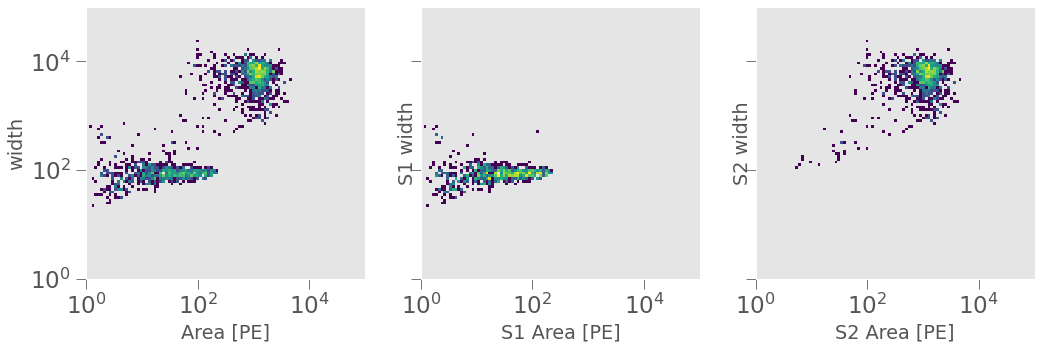

In [32]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.hist2d(peak_basics["area"], peak_basics["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(peak_s1["area"], peak_s1["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(peak_s2["area"], peak_s2["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

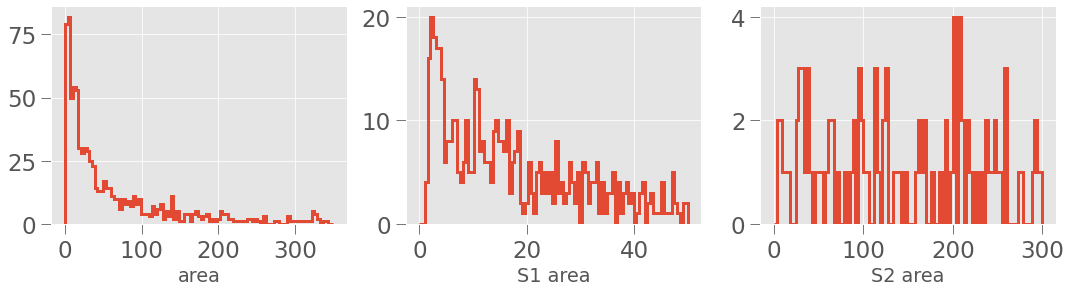

In [33]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18,4))
ax0.hist(peak_basics['area'], bins=np.linspace(0, 350, 100), histtype='step', lw=3)
ax1.hist(peak_s1['area'], bins=np.linspace(0, 50, 100), histtype='step', lw=3)
ax2.hist(peak_s2['area'], bins=np.linspace(0,300,100), histtype='step', lw=3);
ax0.set_xlabel("area"); ax1.set_xlabel("S1 area"); ax2.set_xlabel("S2 area");

We can try to make peaks using the unchanged context which uses min s1 coincidence threshold as 2 fold.

In [39]:
st_unchanged = A.simulate_one(df, runid)
st_unchanged.show_config("peak_basics").iloc[-6:-5]

/dali/lgrandi/xenonnt/software/cutax/latest/cutax/contexts.py:85: UserWarning: WARNING! You are using SR0 v1 simulation context! Consider updating to a newer version!
  warnings.warn("WARNING! You are using SR0 v1 simulation context! Consider updating to a newer version!")


snsim_02 is created! Returning context!


,option,default,current,applies_to,help
57,s1_min_coincidence,2,<OMITTED>,"(peaklet_classification,)",Minimum tight coincidence necessary to make an S1


In [35]:
_peak_basics = st_unchanged.get_df(runid, "peak_basics")
_peak_s1 = _peak_basics[_peak_basics['type'] == 1]
_peak_s2 = _peak_basics[_peak_basics['type'] == 2]
_peak_basics['type'].unique(), sum(_peak_basics['type']==0), sum(_peak_basics['type']==1), sum(_peak_basics['type']==2)

Loading peak_basics: |          | 0.00 % [00:00<?]

(array([2, 1, 0], dtype=int8), 36, 660, 978)

/tmp/jobs/21865128/ipykernel_319/2527553398.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax0.hist2d(_peak_basics["area"], _peak_basics["range_50p_area"],
/tmp/jobs/21865128/ipykernel_319/2527553398.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax1.hist2d(_peak_s1["area"], _peak_s1["range_50p_area"],
/tmp/jobs/21865128/ipykernel_319/2527553398.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax2.hist2d(_peak_s2["area"], _peak_s2["range_50p_area"],


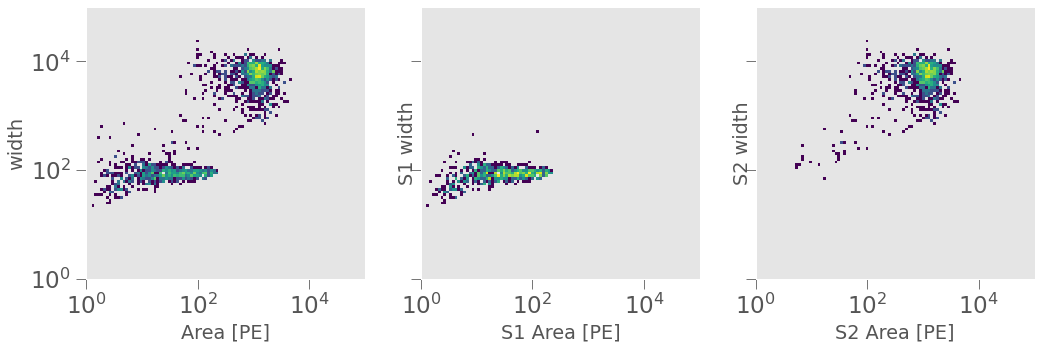

In [36]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.hist2d(_peak_basics["area"], _peak_basics["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(_peak_s1["area"], _peak_s1["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(_peak_s2["area"], _peak_s2["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

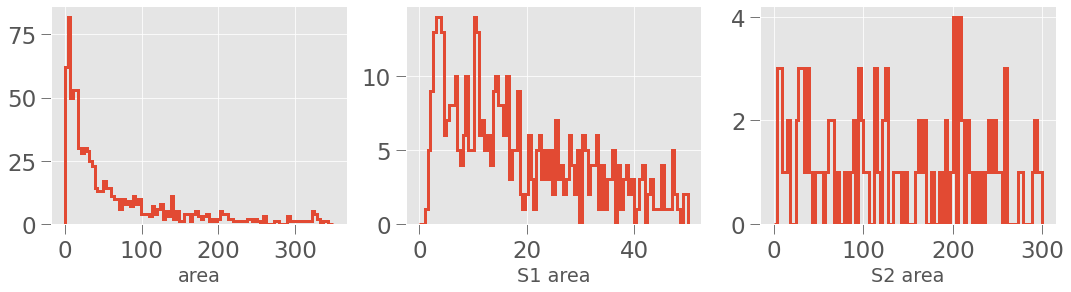

In [37]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18,4))
ax0.hist(_peak_basics['area'], bins=np.linspace(0, 350, 100), histtype='step', lw=3)
ax1.hist(_peak_s1['area'], bins=np.linspace(0, 50, 100), histtype='step', lw=3)
ax2.hist(_peak_s2['area'], bins=np.linspace(0,300,100), histtype='step', lw=3);
ax0.set_xlabel("area"); ax1.set_xlabel("S1 area"); ax2.set_xlabel("S2 area");

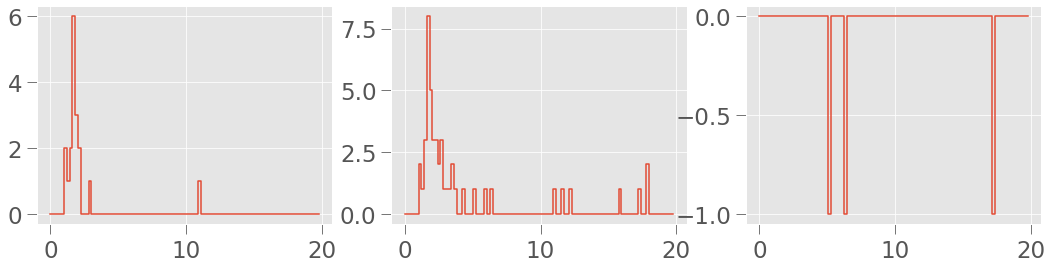

In [38]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18,4))
a, b = np.histogram(peak_basics['area'], bins=np.linspace(0,20,100))
_a = np.histogram(_peak_basics['area'], bins=np.linspace(0,20,100))[0]
ax0.step(b[:-1], a-_a);

a, b = np.histogram(peak_s1['area'], bins=np.linspace(0,20,100))
_a = np.histogram(_peak_s1['area'], bins=np.linspace(0,20,100))[0]
ax1.step(b[:-1], a-_a);

a, b = np.histogram(peak_s2['area'], bins=np.linspace(0,20,100))
_a = np.histogram(_peak_s2['area'], bins=np.linspace(0,20,100))[0]
ax2.step(b[:-1], a-_a);

Extra: The utilix package allows for easy job submission, however, I haven't implemented that yet.

In [ ]:
# from utilix.batchq import submit_job
# submit_job()